# Real time electricity production

### 1. Basics ###

### 2. Data exploration ###
#####     Seasonal decomposition ##### 
#####     Statinarity of  ```'Consommation (MW)'``` ##### 
#####     Visualization of  ```'Consommation (MW)'``` ##### 
#####     Auto-correlation and partial auto-correlation on ```'Consommation (MW)'``` ##### 

### 3. More treatment and filtering ###

### 4. Prophet ###

### 5. Trained models - SARIMA, SARIMAX ###
#####     Model evaluation on past data #####
#####     Model Improvement ##### 
#####     slidding period ##### 
#####     SARIMA, step time: 1h ##### 
#####     SARIMA, step time: 15min ##### 

### Basic librairies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
from datetime import datetime as dt
import sys

### Load dataset

#### From a request

In [2]:
import requests

In [3]:
BASE_URL_pre = 'https://opendata.reseaux-energies.fr/api/v2/catalog/datasets/'
BASE_URL_port = '/exports/json?rows=-1&pretty=false&timezone=UTC'
real_time_elec = 'eco2mix-national-tr'
temperature = 'temperature-quotidienne-regionale'

In [4]:
response_elec = requests.get(BASE_URL_pre + real_time_elec + BASE_URL_port)
response_temeprature = requests.get(BASE_URL_pre + temperature + BASE_URL_port)

In [5]:
response_elec

<Response [200]>

In [6]:
response_temeprature

<Response [200]>

In [7]:
df = pd.DataFrame(response_elec.json())
df_temp = pd.DataFrame(response_temeprature.json())

In [8]:
df.head()

,tch_gaz_tac,hydraulique_step_turbinage,tch_bioenergies,tch_gaz_autres,bioenergies_biomasse,tch_bioenergies_biomasse,tco_bioenergies_dechets,tco_hydraulique,hydraulique_lacs,eolien,...,tch_hydraulique_lacs,column_79,date_heure,tco_hydraulique_step_turbinage,tch_fioul_cogen,charbon,fioul_tac,ech_comm_angleterre,tco_fioul,consommation
0,-0.28,652.0,34.68,0.0,337.0,49.78,0.41,23.53,1598.0,2888.0,...,16.75,None,2020-05-06T03:45:00+00:00,1.78,4.88,10.0,2.0,NaN,0.38,36557.0
1,-0.28,1378.0,33.88,0.0,321.0,47.42,0.37,24.16,1743.0,2459.0,...,18.27,None,2020-05-06T05:30:00+00:00,3.42,4.88,11.0,2.0,-1605.0,0.34,40319.0
2,-0.14,492.0,33.97,0.0,323.0,47.71,0.33,19.06,1338.0,1372.0,...,14.03,None,2020-05-06T08:45:00+00:00,1.08,4.88,-1.0,83.0,NaN,0.48,45450.0
3,-0.28,501.0,34.58,0.0,336.0,49.63,0.32,18.42,1309.0,1518.0,...,13.72,None,2020-05-06T09:45:00+00:00,1.07,4.88,1.0,82.0,NaN,0.47,46823.0
4,-0.28,571.0,34.63,0.0,335.0,49.48,0.33,18.15,1435.0,1583.0,...,15.04,None,2020-05-06T12:15:00+00:00,1.24,4.88,6.0,2.0,NaN,0.30,46106.0


#### Data localy 

In [2]:
# Electricity consumption data
filepath = os.path.join('..', 'raw-data', 'eco2mix-national-tr.csv')
df = pd.read_csv(filepath, delimiter=';')

In [3]:
# Temperature 
temp_filepath = os.path.join('..', 'processed-data', 'temp_05_2020.df')
temp = pd.read_pickle(temp_filepath)

### Data preprocessing

In [9]:
df = pd.DataFrame(response_elec.json())

# Recast date time to datetime type
df['date_heure'] = pd.to_datetime(df['date_heure'])
df.index = df['date_heure']
df['day'] = df['date_heure'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['week_day'] = df['date_heure'].apply(lambda x: x.strftime('%A'))
df['week_number'] = df['date_heure'].apply(lambda x: x.strftime('%W'))
df['minutes'] = df['date_heure'].apply(lambda x: x.strftime('%M'))

# Sort data by datetime
df = df.sort_index()

# Remove useless columns and lines full of NA (futur lines)
col_to_drop = ['ech_comm_angleterre', 'ech_comm_espagne',
               'ech_comm_italie', 'ech_comm_suisse', 'ech_comm_allemagne_belgique',
              'perimetre', 'nature', 'date', 'heure', 'column_79']

df = df.drop(col_to_drop, axis=1)
df = df.dropna()

# Reorder the columns to have the new datetime columns in first
col_reindex =  np.array(df.columns)
col_reindex = np.concatenate((col_reindex[-5:], col_reindex[:-5]), axis=0)

df = df.reindex(columns=col_reindex)

##### Same dataframe to pickle

In [30]:
# import pickle
# path_to_save = os.path.join('..', 'processed-data', 'real_time_elec_production_may.df')
# with open(path_to_save, 'wb') as f:
#     pickle.dump(df, f)

## 2. Data Exploration

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [10]:
from sklearn.metrics import mean_squared_error

### Auto-correlation and partial auto-correlation on ```'Consommation (MW)'```

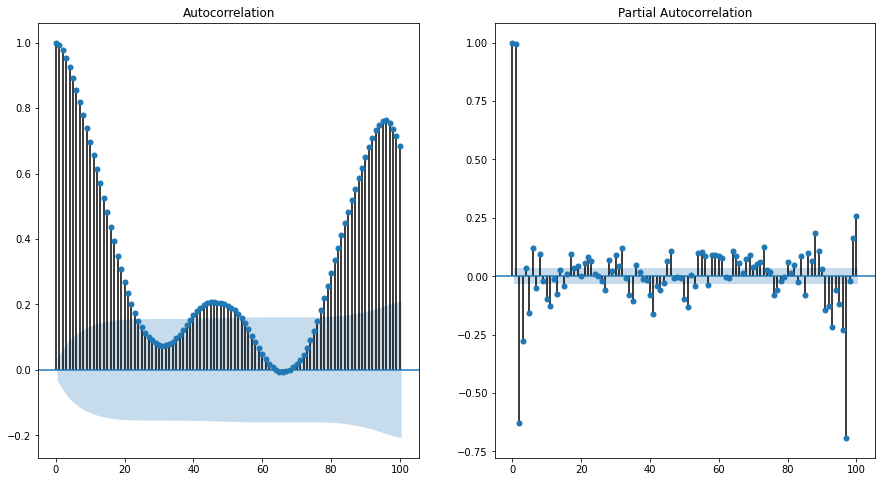

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15,8))

fig = plot_acf(df['Consommation (MW)'], lags=100, ax=axes[0])
fig = plot_pacf(df['Consommation (MW)'], lags=100, ax=axes[1])

### Visualization of  ```'Consommation (MW)'```

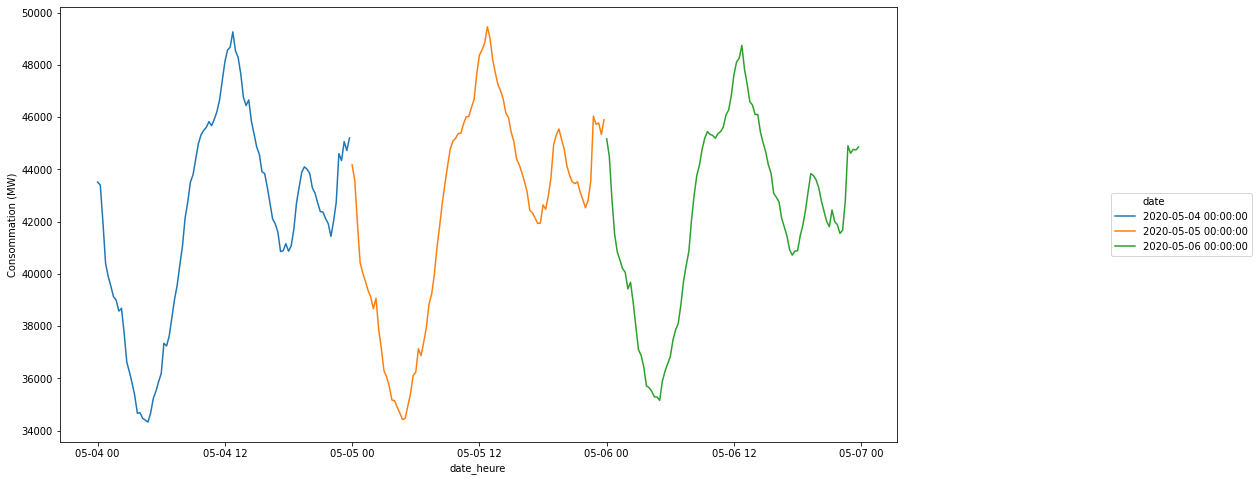

In [9]:
plt.figure(figsize=(15, 8))

first_day = 4
nb_of_days = 3

index_i = (first_day - 1) * 96
index_f = (first_day + nb_of_days -1) * 96

sns.lineplot(data=df.iloc[index_i:index_f, :5], x='date_heure', y='Consommation (MW)', 
             hue='date', palette='tab10')

plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

plt.show()

### Statinarity of  ```'Consommation (MW)'```

In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Consommation (MW)'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.705281
p-value: 0.000001
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [6]:
train_start = '2020-05-04 00:00:00+02:00'
train_end = '2020-05-06 23:45:00+02:00'
test_start = '2020-05-07 00:00:00+02:00'
test_end = '2020-05-07 23:45:00+02:00'

train_days = df['Consommation (MW)']\
    .loc[train_start:train_end]
test_day = df['Consommation (MW)']\
    .loc[test_start:test_end]

In [7]:
len(test_day)

96

In [12]:
result = adfuller(train_days)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.285866
p-value: 0.000006
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572


/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


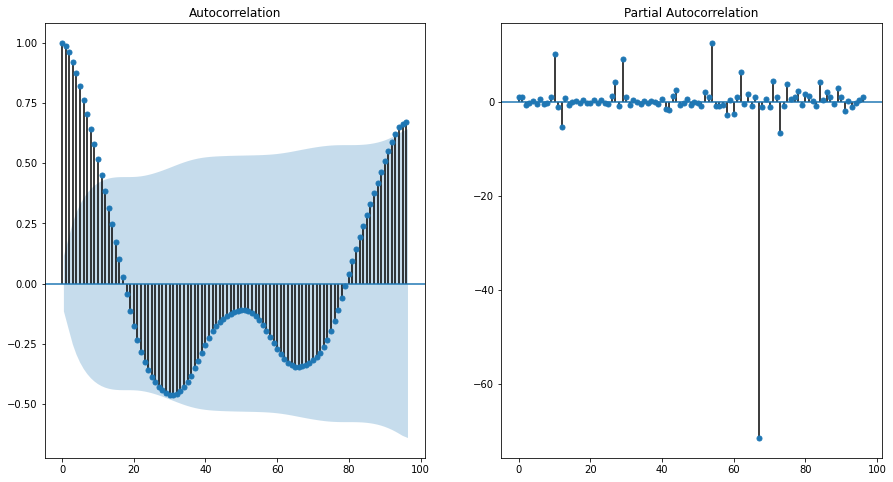

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15,8))

fig = plot_acf(train_days, lags=96, ax=axes[0])
fig = plot_pacf(train_days, lags=96, ax=axes[1])

### Seasonal decomposition

In [58]:
decomposition = seasonal_decompose(train_days, freq=96, extrapolate_trend='freq')

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


<Figure size 864x576 with 0 Axes>

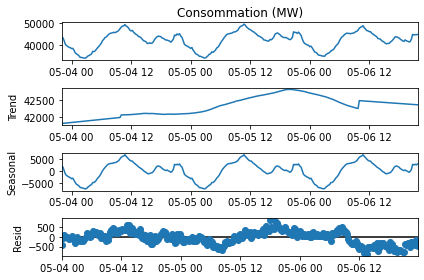

In [59]:
plt.figure(figsize=(12,8))
decomposition.plot()
plt.show()

In [60]:
decomposition.trend

date_heure
2020-05-04 00:00:00+02:00    41815.018663
2020-05-04 00:15:00+02:00    41818.729108
2020-05-04 00:30:00+02:00    41822.439553
2020-05-04 00:45:00+02:00    41826.149998
2020-05-04 01:00:00+02:00    41829.860443
                                 ...     
2020-05-06 22:45:00+02:00    42371.347475
2020-05-06 23:00:00+02:00    42368.775883
2020-05-06 23:15:00+02:00    42366.204292
2020-05-06 23:30:00+02:00    42363.632700
2020-05-06 23:45:00+02:00    42361.061108
Name: trend, Length: 288, dtype: float64

## 3. More treatment and filtering

In [10]:
# Transform to hourly dataframe
df_light = df[df['minutes'] == '00']
df_light = df_light.drop(['minutes'], axis=1)

# Add an hourly frequency to the index and forward filling if some hours are missing
df_light = df_light.asfreq('H', method='ffill')

# Remove all columns except time and conumption columns
df_light = df_light[['date_heure', 'day', 'consommation', 'week_day', 'week_number']]

# Remove values for the current day
df_light = df_light[~df_light['date_heure'].astype(str).str.contains(dt.now().strftime('%Y-%m-%d'))]

# Type of day
# Weekday : 1
# Saturday : 0
# Free days and Sunday : -1
df_light['type_of_day'] = df_light['week_day']\
    .apply(lambda x: -1 if x == 'Sunday' else(0 if x == 'Saturday' else 1))

def free_day(df, date):
    df['type_of_day'][df['date_heure'].astype(str).str.contains(date)] = -1
    return df

free_day(df_light, '2020-05-01')
free_day(df_light, '2020-05-08')
free_day(df_light, '2020-05-10')
free_day(df_light, '2020-05-21')

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date_heure,day,consommation,week_day,week_number,type_of_day
date_heure,,,,,,
2020-04-30 22:00:00+00:00,2020-04-30 22:00:00+00:00,2020-04-30,45533.0,Thursday,17,1
2020-04-30 23:00:00+00:00,2020-04-30 23:00:00+00:00,2020-04-30,41155.0,Thursday,17,1
2020-05-01 00:00:00+00:00,2020-05-01 00:00:00+00:00,2020-05-01,39923.0,Friday,17,-1
2020-05-01 01:00:00+00:00,2020-05-01 01:00:00+00:00,2020-05-01,37018.0,Friday,17,-1
2020-05-01 02:00:00+00:00,2020-05-01 02:00:00+00:00,2020-05-01,35217.0,Friday,17,-1
...,...,...,...,...,...,...
2020-06-21 19:00:00+00:00,2020-06-21 19:00:00+00:00,2020-06-21,38241.0,Sunday,24,-1
2020-06-21 20:00:00+00:00,2020-06-21 20:00:00+00:00,2020-06-21,38380.0,Sunday,24,-1
2020-06-21 21:00:00+00:00,2020-06-21 21:00:00+00:00,2020-06-21,41798.0,Sunday,24,-1


In [68]:
# Temperature

temp['date'] = temp.index
temp['date'] = temp['date'].apply(lambda x: dt.strptime(x, '%Y-%m-%d'))

df_light['TMoy (°C)'] = df_light['date']\
    .apply(lambda x: temp['TMoy (°C)'][temp['date'] == x].iloc[0])

df_light['TMin (°C)'] = df_light['date']\
    .apply(lambda x: temp['TMin (°C)'][temp['date'] == x].iloc[0])

df_light['TMax (°C)'] = df_light['date']\
    .apply(lambda x: temp['TMax (°C)'][temp['date'] == x].iloc[0])

In [190]:
# path_to_save = os.path.join('..', 'processed-data', 'hourly_elec_prod_may.df')
# with open(path_to_save, 'wb') as f:
#     pickle.dump(df_light, f)

## 4. Prophet

In [4]:
!ls ../real-time-model

make_evaluation_models.py  model-evaluation.py	 models  __pycache__  utils.py
make_models.py		   model-grid-search.py  other	 score.csv


In [5]:
import sys
sys.path.append('../real-time-model')
from make_models import df_light

Data from https://opendata.reseaux-energies.fr/api/v2/catalog/datasets/eco2mix-national-tr/exports/json?rows=-1&pretty=false&timezone=UTC successfully loaded


../real-time-model/utils.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type_of_day'][df['date_heure'].astype(str).str.contains(date)] = -1


In [22]:
from fbprophet import Prophet
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [23]:
prophet_train_days = df_light[['date_heure', 'consommation']].iloc[-240:, :]\
                .rename(columns={'date_heure': 'ds', 'consommation': 'y'})

prophet_train_days['ds'] = prophet_train_days['ds']\
    .apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))

In [24]:
model = Prophet().fit(prophet_train_days)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [25]:
future = model.make_future_dataframe(periods=24, freq='H')
forecast = model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-15 00:00:00,43186.236491,36187.331303,40591.413255,43186.236491,43186.236491,-4788.522551,-4788.522551,-4788.522551,-4788.522551,-4788.522551,-4788.522551,0.0,0.0,0.0,38397.713940
1,2020-06-15 01:00:00,43201.483929,33141.502589,37733.956932,43201.483929,43201.483929,-7833.145579,-7833.145579,-7833.145579,-7833.145579,-7833.145579,-7833.145579,0.0,0.0,0.0,35368.338350
2,2020-06-15 02:00:00,43216.731368,31357.652555,36086.854859,43216.731368,43216.731368,-9563.051311,-9563.051311,-9563.051311,-9563.051311,-9563.051311,-9563.051311,0.0,0.0,0.0,33653.680057
3,2020-06-15 03:00:00,43231.978806,31892.336855,36203.361426,43231.978806,43231.978806,-9154.310134,-9154.310134,-9154.310134,-9154.310134,-9154.310134,-9154.310134,0.0,0.0,0.0,34077.668672
4,2020-06-15 04:00:00,43247.226244,34155.909536,38681.944719,43247.226244,43247.226244,-6874.797989,-6874.797989,-6874.797989,-6874.797989,-6874.797989,-6874.797989,0.0,0.0,0.0,36372.428255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2020-06-25 19:00:00,47776.161035,45997.101941,50693.716419,47134.102083,48368.307601,627.886719,627.886719,627.886719,627.886719,627.886719,627.886719,0.0,0.0,0.0,48404.047755
260,2020-06-25 20:00:00,47833.180123,45852.787576,50486.259238,47133.594033,48475.278226,404.493688,404.493688,404.493688,404.493688,404.493688,404.493688,0.0,0.0,0.0,48237.673811
261,2020-06-25 21:00:00,47890.199211,45808.078015,50529.833743,47142.703994,48580.343500,408.875312,408.875312,408.875312,408.875312,408.875312,408.875312,0.0,0.0,0.0,48299.074523
262,2020-06-25 22:00:00,47947.218299,45576.454150,50200.513281,47142.512030,48688.445147,-101.220549,-101.220549,-101.220549,-101.220549,-101.220549,-101.220549,0.0,0.0,0.0,47845.997751


In [31]:
prophet_train_days

,ds,y
date_heure,,
2020-06-15 00:00:00+00:00,2020-06-15 00:00,35552.0
2020-06-15 01:00:00+00:00,2020-06-15 01:00,33414.0
2020-06-15 02:00:00+00:00,2020-06-15 02:00,32174.0
2020-06-15 03:00:00+00:00,2020-06-15 03:00,32734.0
2020-06-15 04:00:00+00:00,2020-06-15 04:00,34746.0
...,...,...
2020-06-24 19:00:00+00:00,2020-06-24 19:00,44913.0
2020-06-24 20:00:00+00:00,2020-06-24 20:00,44290.0
2020-06-24 21:00:00+00:00,2020-06-24 21:00,48113.0


In [33]:
forecast.iloc[-24:, :]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
240,2020-06-25 00:00:00,46692.798363,39688.832240,44131.365132,46692.798363,46692.798363,-4788.522551,-4788.522551,-4788.522551,-4788.522551,-4788.522551,-4788.522551,0.0,0.0,0.0,41904.275812
241,2020-06-25 01:00:00,46749.817451,36647.749610,41018.653479,46749.815913,46749.817451,-7833.145579,-7833.145579,-7833.145579,-7833.145579,-7833.145579,-7833.145579,0.0,0.0,0.0,38916.671872
242,2020-06-25 02:00:00,46806.836539,35084.464862,39497.459309,46798.186973,46809.829460,-9563.051311,-9563.051311,-9563.051311,-9563.051311,-9563.051311,-9563.051311,0.0,0.0,0.0,37243.785229
243,2020-06-25 03:00:00,46863.855627,35517.669276,39773.826475,46837.256129,46878.833993,-9154.310134,-9154.310134,-9154.310134,-9154.310134,-9154.310134,-9154.310134,0.0,0.0,0.0,37709.545494
244,2020-06-25 04:00:00,46920.874715,37683.861730,42292.661921,46873.762374,46950.421097,-6874.797989,-6874.797989,-6874.797989,-6874.797989,-6874.797989,-6874.797989,0.0,0.0,0.0,40046.076726
245,2020-06-25 05:00:00,46977.893803,40884.292460,45272.867027,46910.040153,47028.695212,-3734.682461,-3734.682461,-3734.682461,-3734.682461,-3734.682461,-3734.682461,0.0,0.0,0.0,43243.211343
246,2020-06-25 06:00:00,47034.912891,44149.242310,48313.016479,46945.595567,47106.194931,-686.674974,-686.674974,-686.674974,-686.674974,-686.674974,-686.674974,0.0,0.0,0.0,46348.237917
247,2020-06-25 07:00:00,47091.931979,46820.431469,51077.940202,46968.373086,47197.369527,1890.025921,1890.025921,1890.025921,1890.025921,1890.025921,1890.025921,0.0,0.0,0.0,48981.957900
248,2020-06-25 08:00:00,47148.951067,48943.543974,53471.119713,46994.918053,47286.234575,4047.247433,4047.247433,4047.247433,4047.247433,4047.247433,4047.247433,0.0,0.0,0.0,51196.198501
249,2020-06-25 09:00:00,47205.970155,50969.998066,55199.013141,47014.813487,47378.070796,5766.254853,5766.254853,5766.254853,5766.254853,5766.254853,5766.254853,0.0,0.0,0.0,52972.225008


<Figure size 1296x576 with 0 Axes>

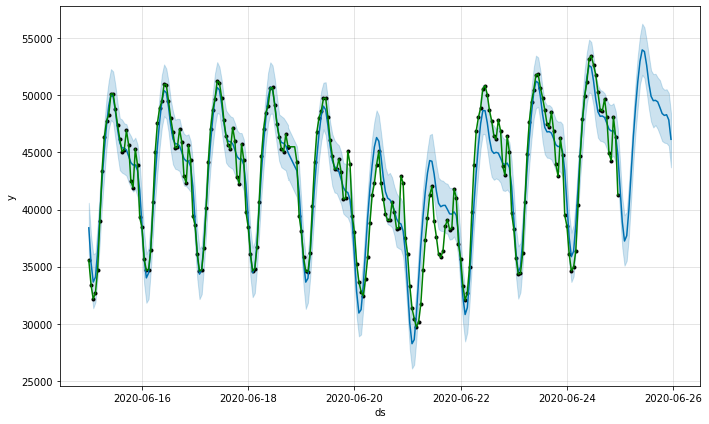

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))

model.plot(forecast)

plt.plot(prophet_train_days['y'], c='g')

# plt.plot(test_day, c='r')

plt.show()

## 5. Trained models - SARIMA, SARIMAX

### SARIMA, step time: 15min

In [8]:
train_start = '2020-05-04 00:00:00+02:00'
train_end = '2020-05-06 23:45:00+02:00'
test_start = '2020-05-07 00:00:00+02:00'
test_end = '2020-05-07 23:45:00+02:00'

train_days = df['Consommation (MW)']\
    .loc[train_start:train_end]
test_day = df['Consommation (MW)']\
    .loc[test_start:test_end]

In [40]:
path_model_dict = os.path.join('..', 'real-time-model', 'models', 'prediction-list')
with open(path_model_dict, 'rb') as f:
    model_dict = pickle.load(f)

path_model_csv = os.path.join('..', 'real-time-model', 'score.csv')
model_df = pd.read_csv(path_model_csv)

In [44]:
model_df = model_df.sort_values(by=['mse_score'])

In [46]:
model_df.head()

,model_name,mse_score
1,SARIMA_order=(50-1-10)_seasonal_order=(1-1-1-96),197952.495181
4,SARIMA_order=(50-1-10)_seasonal_order=(0-1-1-96),198383.280125
11,SARIMA_order=(50-1-10)_seasonal_order=(0-1-0-96),227809.169426
18,SARIMA_order=(50-1-20)_seasonal_order=(1-1-0-96),229482.164389
0,SARIMA_order=(50-1-20)_seasonal_order=(0-1-1-96),367139.523867


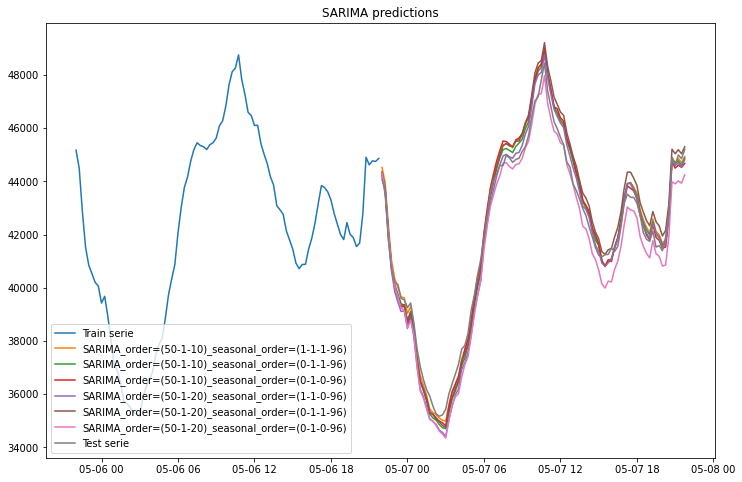

In [51]:
plt.figure(figsize=(12,8))

plt.plot(train_days[192:], label='Train serie')

for i in range(6):
    plt.plot(model_dict[model_df.iloc[i, 0]], label=model_df.iloc[i, 0])

plt.plot(test_day, label="Test serie")

plt.title("SARIMA predictions")
plt.legend()

plt.show()

### SARIMA, step time: 1h

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
!ls ../real-time-model

model-evaluation.py  models  models.py	other  __pycache__  score.csv


In [104]:
sys.path.append(os.path.join('..', 'real-time-model'))
from models import train_days, test_day, exog_train, exog_test, AR

In [105]:
path_model_dict = os.path.join('..', 'real-time-model', 'models', '24h-prediction-list')
with open(path_model_dict, 'rb') as f:
    model_dict = pickle.load(f)

path_model_csv = os.path.join('..', 'real-time-model', 'score.csv')
model_df = pd.read_csv(path_model_csv)

In [10]:
model_df = model_df.sort_values(by=['mse_score'])

In [11]:
model_df = model_df.drop_duplicates()
len(model_df)

292

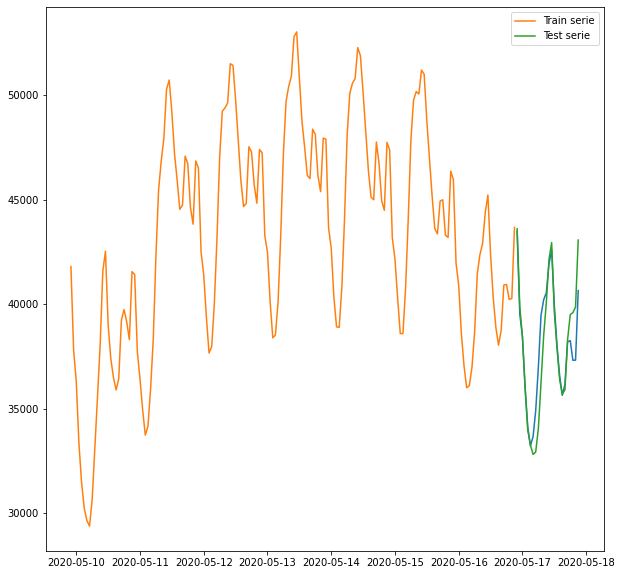

In [25]:
plt.figure(figsize=(10, 10))

plt.plot(model_dict['SARIMA_or=(10-1-1)_seor=(1-1-1-24_exog_scaled)'])

plt.plot(train_days, label="Train serie")
plt.plot(test_day, label="Test serie")
plt.legend()
plt.show()

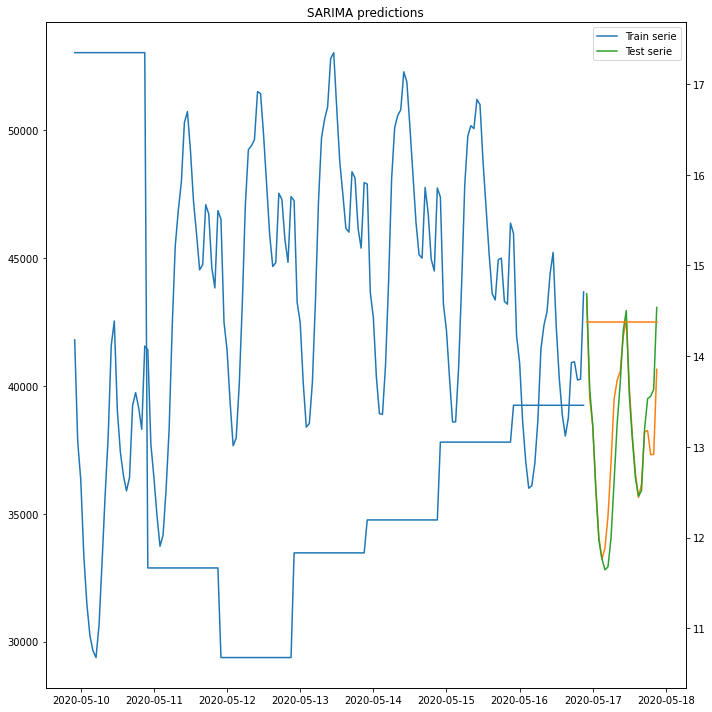

In [26]:
fig, ax1 = plt.subplots(figsize=(10, 10))

ax2 = ax1.twinx()

ax1.plot(train_days, label='Train serie')
ax2.plot(train_exog['TMoy (°C)'], label='AVG temperature')
ax2.plot(test_exog['TMoy (°C)'], label='AVG temperature')

# for i in range(5):
#     ax1.plot(model_dict[model_df.iloc[i, 0]], label=model_df.iloc[i, 0])

ax1.plot(model_dict['SARIMA_or=(10-1-1)_seor=(1-1-1-24_exog_scaled)'])

ax1.plot(test_day, label="Test serie")

plt.title("SARIMA predictions")
ax1.legend()

fig.tight_layout()

plt.show()

### slidding period

In [106]:
import os
import pickle
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [34]:
path_to_df_light = os.path.join('..', 'processed-data', 'hourly_elec_prod_may.df')
df_light = pd.read_pickle(path_to_df_light)

In [35]:
df_light

,date_heure,date,week_day,week_number,Consommation (MW),Prévision J-1 (MW),Prévision J (MW),Fioul (MW),Charbon (MW),Gaz (MW),...,TCO Bioénergies - Déchets (%),TCH Bioénergies - Déchets (%),TCO Bioénergies - Biomasse (%),TCH Bioénergies - Biomasse (%),TCO Bioénergies - Biogaz (%),TCH Bioénergies - Biogaz (%),TMoy (°C),TMin (°C),TMax (°C),type_of_day
date_heure,,,,,,,,,,,,,,,,,,,,,
2020-05-01 00:00:00+02:00,2020-05-01 00:00:00+02:00,2020-05-01,Friday,17,45533.0,46100,45700.0,140.0,13.0,555.0,...,0.40,19.20,0.73,48.90,0.55,50.30,13.158462,9.300000,17.017692,-1
2020-05-01 01:00:00+02:00,2020-05-01 01:00:00+02:00,2020-05-01,Friday,17,41155.0,41900,41400.0,139.0,11.0,547.0,...,0.45,19.41,0.81,48.90,0.61,50.30,13.158462,9.300000,17.017692,-1
2020-05-01 02:00:00+02:00,2020-05-01 02:00:00+02:00,2020-05-01,Friday,17,39923.0,41100,40900.0,139.0,14.0,544.0,...,0.46,19.30,0.83,49.04,0.63,50.30,13.158462,9.300000,17.017692,-1
2020-05-01 03:00:00+02:00,2020-05-01 03:00:00+02:00,2020-05-01,Friday,17,37018.0,37600,37100.0,135.0,13.0,544.0,...,0.51,19.94,0.90,49.04,0.68,50.30,13.158462,9.300000,17.017692,-1
2020-05-01 04:00:00+02:00,2020-05-01 04:00:00+02:00,2020-05-01,Friday,17,35217.0,35200,35300.0,135.0,14.0,537.0,...,0.52,19.30,0.94,48.90,0.72,50.30,13.158462,9.300000,17.017692,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31 19:00:00+02:00,2020-05-31 19:00:00+02:00,2020-05-31,Sunday,21,36411.0,38500,36700.0,133.0,10.0,789.0,...,0.48,18.46,0.88,47.56,0.69,49.51,18.156923,11.663846,24.650000,-1
2020-05-31 20:00:00+02:00,2020-05-31 20:00:00+02:00,2020-05-31,Sunday,21,36789.0,39300,37600.0,133.0,9.0,781.0,...,0.48,18.78,0.87,47.42,0.68,49.51,18.156923,11.663846,24.650000,-1
2020-05-31 21:00:00+02:00,2020-05-31 21:00:00+02:00,2020-05-31,Sunday,21,36112.0,38200,36800.0,133.0,9.0,790.0,...,0.50,18.88,0.89,47.56,0.70,49.51,18.156923,11.663846,24.650000,-1


In [108]:
periods = [3, 7, 15, 21, 28]
i = 0

mse = list()
predictions = list()

for period in tqdm(periods):

    train_days = df_light['Consommation (MW)'].iloc[i:(i + period) * 24]
    test_day = df_light['Consommation (MW)'].iloc[(i + period) * 24:(i + period) * 24 + 24]
    exog_train = df_light[['TMoy (°C)', 'type_of_day']].iloc[i:(i + period) * 24, :]
    exog_test = df_light[['TMoy (°C)', 'type_of_day']].iloc[(i + period) * 24:(i + period) * 24 + 24, :]

    model = SARIMAX(train_days, order=(10, 1, 1), seasonal_order=(1, 1, 1, 24), exog=exog_train)

    model_fit = model.fit(disp=False)

    prediction = model_fit.get_prediction(start=test_day.index[0], end=test_day.index[-1], exog=exog_test)
    
    predictions.append(prediction.predicted_mean)
    mse.append(mean_squared_error(test_day, prediction.predicted_mean))

  0%|          | 0/5 [00:00<?, ?it/s]/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check 

In [109]:
mse

[38873096.260280475,
 20292374.950983275,
 17093429.732487623,
 3162382.712358097,
 310839.93905716727]

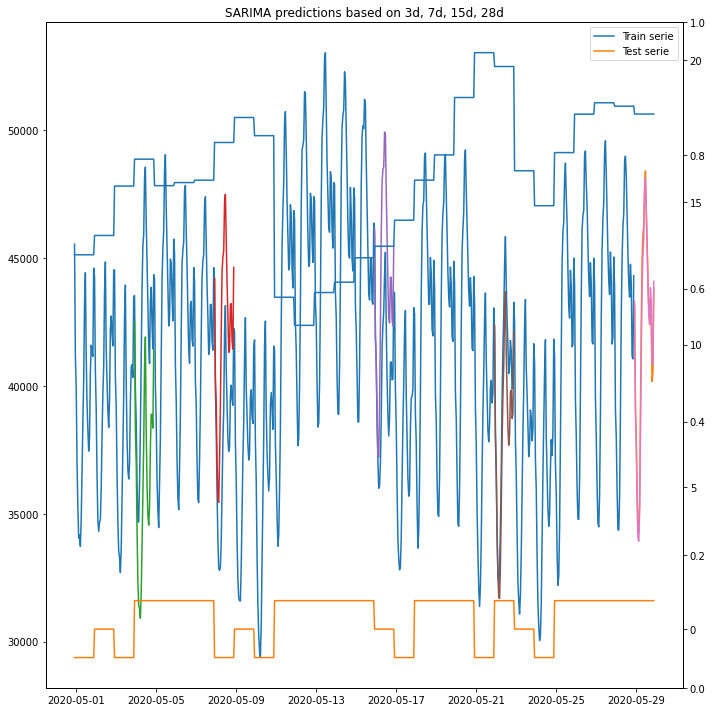

In [112]:
fig, ax1 = plt.subplots(figsize=(10, 10))

ax2 = ax1.twinx()
ax3 = ax1.twinx()

ax1.plot(train_days, label='Train serie')
ax1.plot(test_day, label="Test serie")

ax2.plot(pd.concat((exog_train['TMoy (°C)'], exog_test['TMoy (°C)']), axis=0), label='AVG temperature')

ax2.plot(pd.concat((exog_train['type_of_day'], exog_test['type_of_day']), axis=0), label='AVG temperature')

for pred in predictions:
    ax1.plot(pred)

plt.title("SARIMA predictions based on 3d, 7d, 15d, 28d")
ax1.legend()

fig.tight_layout()

plt.show()

In [116]:
%%time
period = 28
# i = [0, 1, 2]

mse = list()
predictions = list()

for i in tqdm(range(3)):

    train_days = df_light['Consommation (MW)'].iloc[i:(i + period) * 24]
    test_day = df_light['Consommation (MW)'].iloc[(i + period) * 24:(i + period) * 24 + 24]
    exog_train = df_light[['TMoy (°C)', 'type_of_day']].iloc[i:(i + period) * 24, :]
    exog_test = df_light[['TMoy (°C)', 'type_of_day']].iloc[(i + period) * 24:(i + period) * 24 + 24, :]

    model = SARIMAX(train_days, order=(10, 1, 1), seasonal_order=(1, 1, 1, 24), exog=exog_train)

    model_fit = model.fit(disp=False)

    prediction = model_fit.get_prediction(start=test_day.index[0], end=test_day.index[-1], exog=exog_test)
    
    predictions.append(prediction.predicted_mean)
    mse.append(mean_squared_error(test_day, prediction.predicted_mean))

  0%|          | 0/3 [00:00<?, ?it/s]/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 33%|███▎      | 1/3 [02:12<04:24, 132.21s/it]/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, V

CPU times: user 22min 17s, sys: 19min 13s, total: 41min 30s
Wall time: 6min 22s


In [117]:
mse

[310839.93905716727, 14517586.535523886, 3975542.4904558402]

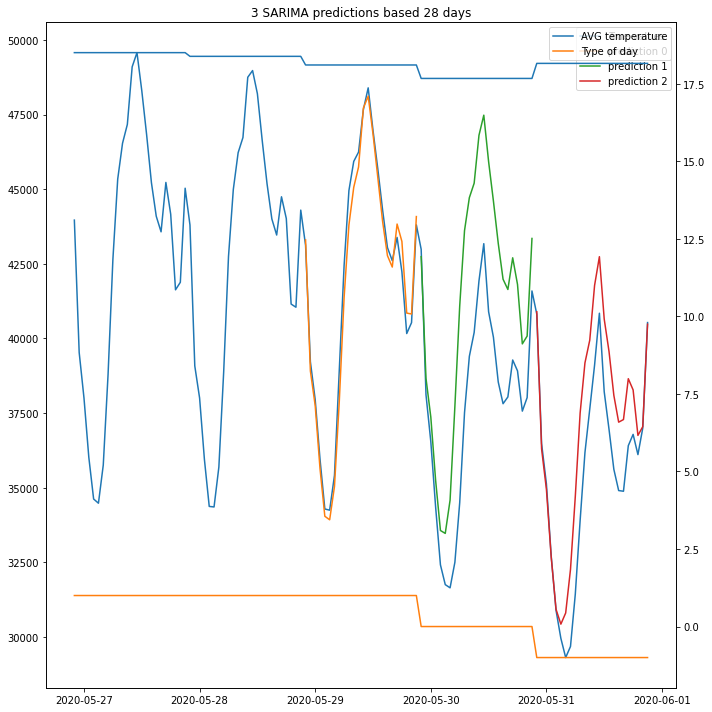

In [127]:
fig, ax1 = plt.subplots(figsize=(10, 10))

ax2 = ax1.twinx()

ax1.plot(pd.concat((train_days, test_day), axis=0).iloc[-120:], label='True values')
# ax1.plot(test_day, label="Test serie")

ax2.plot(pd.concat((exog_train['TMoy (°C)'], exog_test['TMoy (°C)']), axis=0).iloc[-120:], label='AVG temperature')

ax2.plot(pd.concat((exog_train['type_of_day'], exog_test['type_of_day']), axis=0).iloc[-120:], label='Type of day')

for i, pred in enumerate(predictions):
    ax1.plot(pred, label=f'prediction {i}')

plt.title("3 SARIMA predictions based 28 days")
ax1.legend()
ax2.legend()

fig.tight_layout()

plt.show()

In [128]:
%%time
period = 28
# i = [0, 1, 2]

mse = list()
predictions = list()

for i in tqdm(range(1, 3)):

    train_days = df_light['Consommation (MW)'].iloc[i:(i + period) * 24]
    test_day = df_light['Consommation (MW)'].iloc[(i + period) * 24:(i + period) * 24 + 24]
    exog_train = df_light[['TMoy (°C)', 'type_of_day']].iloc[i:(i + period) * 24, :]
    exog_test = df_light[['TMoy (°C)', 'type_of_day']].iloc[(i + period) * 24:(i + period) * 24 + 24, :]

    model = SARIMAX(train_days, order=(10, 1, 1), seasonal_order=(1, 1, 2, 24), exog=exog_train)

    model_fit = model.fit(disp=False)

    prediction = model_fit.get_prediction(start=test_day.index[0], end=test_day.index[-1], exog=exog_test)
    
    predictions.append(prediction.predicted_mean)
    mse.append(mean_squared_error(test_day, prediction.predicted_mean))

  0%|          | 0/2 [00:00<?, ?it/s]/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 50%|█████     | 1/2 [02:46<02:46, 166.37s/it]/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, V

CPU times: user 23min 8s, sys: 13min 49s, total: 36min 58s
Wall time: 5min 30s


In [129]:
mse

[14368961.394585326, 3637176.9079130664]

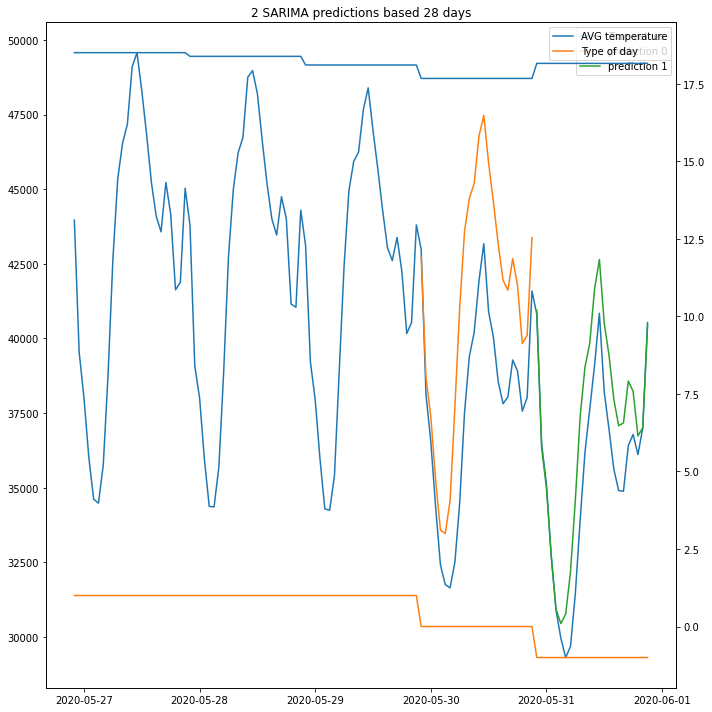

In [130]:
fig, ax1 = plt.subplots(figsize=(10, 10))

ax2 = ax1.twinx()

ax1.plot(pd.concat((train_days, test_day), axis=0).iloc[-120:], label='True values')
# ax1.plot(test_day, label="Test serie")

ax2.plot(pd.concat((exog_train['TMoy (°C)'], exog_test['TMoy (°C)']), axis=0).iloc[-120:], label='AVG temperature')

ax2.plot(pd.concat((exog_train['type_of_day'], exog_test['type_of_day']), axis=0).iloc[-120:], label='Type of day')

for i, pred in enumerate(predictions):
    ax1.plot(pred, label=f'prediction {i}')

plt.title("2 SARIMA predictions based 28 days")
ax1.legend()
ax2.legend()

fig.tight_layout()

plt.show()

In [131]:
%%time
period = 28
# i = [0, 1, 2]

mse = list()
predictions = list()

for i in tqdm(range(2, 3)):

    train_days = df_light['Consommation (MW)'].iloc[i:(i + period) * 24]
    test_day = df_light['Consommation (MW)'].iloc[(i + period) * 24:(i + period) * 24 + 24]
    exog_train = df_light[['TMoy (°C)', 'type_of_day']].iloc[i:(i + period) * 24, :]
    exog_test = df_light[['TMoy (°C)', 'type_of_day']].iloc[(i + period) * 24:(i + period) * 24 + 24, :]

    model = SARIMAX(train_days, order=(10, 1, 1), seasonal_order=(2, 1, 1, 24), exog=exog_train)

    model_fit = model.fit(disp=False)

    prediction = model_fit.get_prediction(start=test_day.index[0], end=test_day.index[-1], exog=exog_test)
    
    predictions.append(prediction.predicted_mean)
    mse.append(mean_squared_error(test_day, prediction.predicted_mean))

  0%|          | 0/1 [00:00<?, ?it/s]/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
100%|██████████| 1/1 [03:07<00:00, 187.97s/it]

CPU times: user 12min 37s, sys: 6min 56s, total: 19min 34s
Wall time: 3min 7s


In [132]:
mse

[3657718.4538160264]

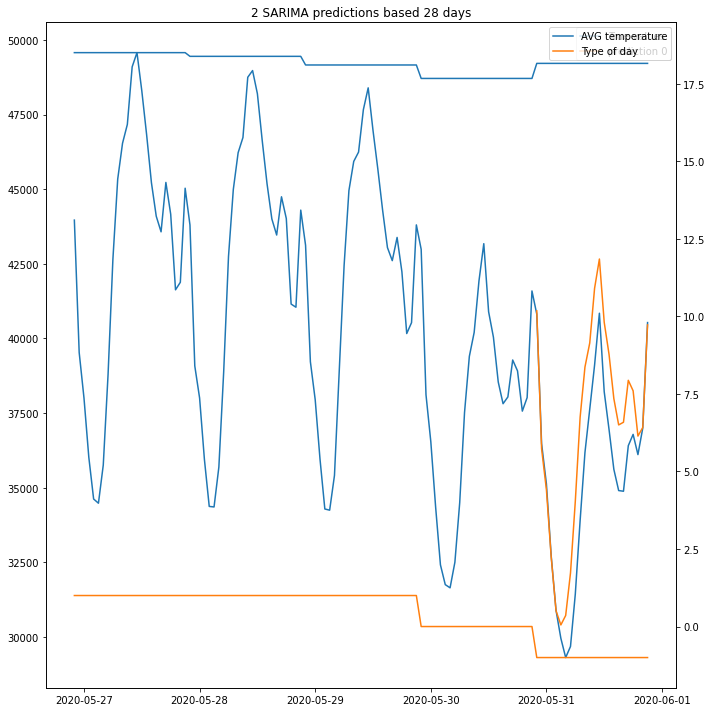

In [133]:
fig, ax1 = plt.subplots(figsize=(10, 10))

ax2 = ax1.twinx()

ax1.plot(pd.concat((train_days, test_day), axis=0).iloc[-120:], label='True values')
# ax1.plot(test_day, label="Test serie")

ax2.plot(pd.concat((exog_train['TMoy (°C)'], exog_test['TMoy (°C)']), axis=0).iloc[-120:], label='AVG temperature')

ax2.plot(pd.concat((exog_train['type_of_day'], exog_test['type_of_day']), axis=0).iloc[-120:], label='Type of day')

for i, pred in enumerate(predictions):
    ax1.plot(pred, label=f'prediction {i}')

plt.title("2 SARIMA predictions based 28 days")
ax1.legend()
ax2.legend()

fig.tight_layout()

plt.show()

In [134]:
%%time
period = 28
# i = [0, 1, 2]

mse = list()
predictions = list()

for i in tqdm(range(2, 3)):

    train_days = df_light['Consommation (MW)'].iloc[i:(i + period) * 24]
    test_day = df_light['Consommation (MW)'].iloc[(i + period) * 24:(i + period) * 24 + 24]
    exog_train = df_light[['TMoy (°C)', 'type_of_day']].iloc[i:(i + period) * 24, :]
    exog_test = df_light[['TMoy (°C)', 'type_of_day']].iloc[(i + period) * 24:(i + period) * 24 + 24, :]

    model = SARIMAX(train_days, order=(10, 1, 1), seasonal_order=(1, 1, 3, 24), exog=exog_train)

    model_fit = model.fit(disp=False)

    prediction = model_fit.get_prediction(start=test_day.index[0], end=test_day.index[-1], exog=exog_test)
    
    predictions.append(prediction.predicted_mean)
    mse.append(mean_squared_error(test_day, prediction.predicted_mean))

  0%|          | 0/1 [00:00<?, ?it/s]/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
100%|██████████| 1/1 [07:14<00:00, 434.81s/it]

CPU times: user 33min 56s, sys: 22min 40s, total: 56min 37s
Wall time: 7min 14s


In [135]:
mse

[2708193.443212001]

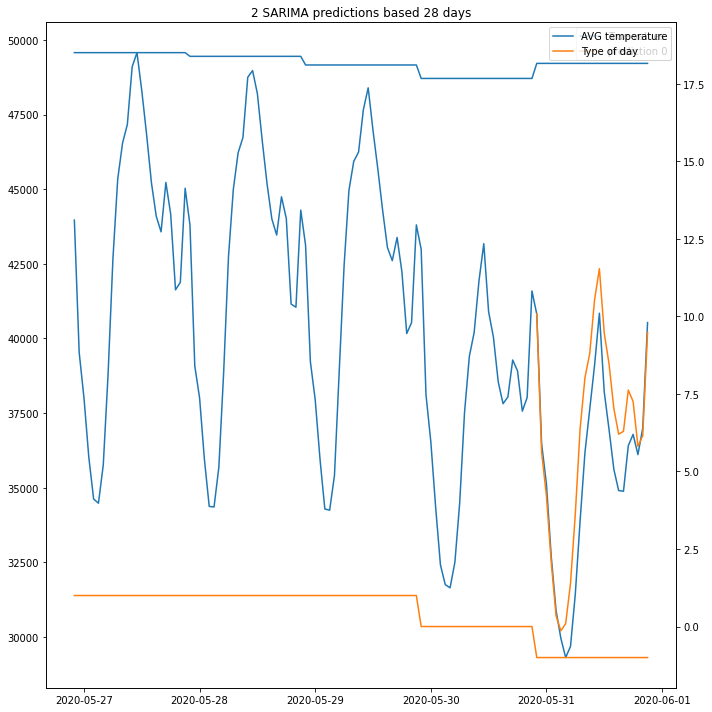

In [136]:
fig, ax1 = plt.subplots(figsize=(10, 10))

ax2 = ax1.twinx()

ax1.plot(pd.concat((train_days, test_day), axis=0).iloc[-120:], label='True values')
# ax1.plot(test_day, label="Test serie")

ax2.plot(pd.concat((exog_train['TMoy (°C)'], exog_test['TMoy (°C)']), axis=0).iloc[-120:], label='AVG temperature')

ax2.plot(pd.concat((exog_train['type_of_day'], exog_test['type_of_day']), axis=0).iloc[-120:], label='Type of day')

for i, pred in enumerate(predictions):
    ax1.plot(pred, label=f'prediction {i}')

plt.title("2 SARIMA predictions based 28 days")
ax1.legend()
ax2.legend()

fig.tight_layout()

plt.show()

In [140]:
%%time
period = 28
# i = [0, 1, 2]

mse = list()
predictions = list()

for i in tqdm(range(2, 3)):

    train_days = df_light['Consommation (MW)'].iloc[i:(i + period) * 24]
    test_day = df_light['Consommation (MW)'].iloc[(i + period) * 24:(i + period) * 24 + 24]
    exog_train = df_light[['TMoy (°C)', 'type_of_day']].iloc[i:(i + period) * 24, :]
    exog_test = df_light[['TMoy (°C)', 'type_of_day']].iloc[(i + period) * 24:(i + period) * 24 + 24, :]

    model = SARIMAX(train_days, order=(10, 1, 1), seasonal_order=(1, 1, 4, 24), exog=exog_train)

    model_fit = model.fit(disp=False)

    prediction = model_fit.get_prediction(start=test_day.index[0], end=test_day.index[-1], exog=exog_test)
    
    predictions.append(prediction.predicted_mean)
    mse.append(mean_squared_error(test_day, prediction.predicted_mean))

  0%|          | 0/1 [00:00<?, ?it/s]/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
100%|██████████| 1/1 [10:41<00:00, 641.94s/it]

CPU times: user 50min 47s, sys: 31min 8s, total: 1h 21min 55s
Wall time: 10min 41s


In [141]:
mse

[3106654.8153249696]

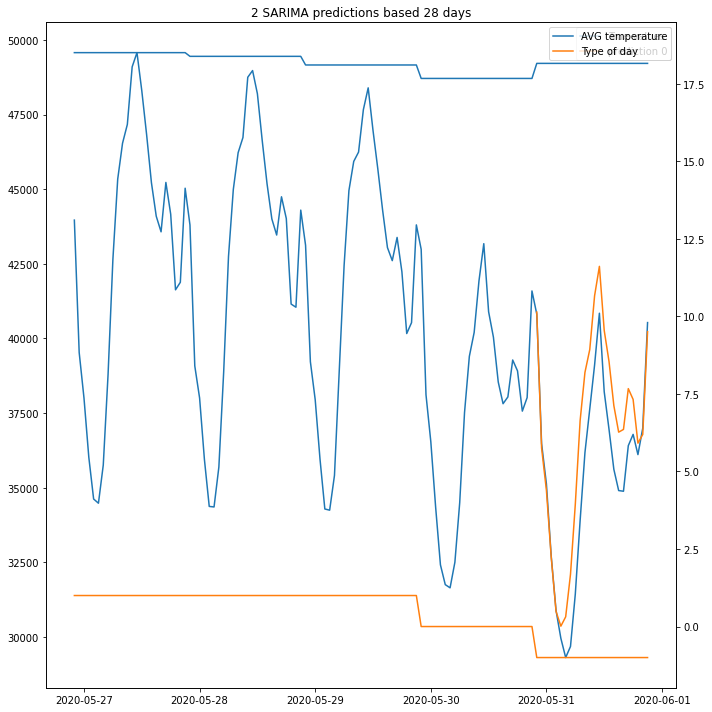

In [142]:
fig, ax1 = plt.subplots(figsize=(10, 10))

ax2 = ax1.twinx()

ax1.plot(pd.concat((train_days, test_day), axis=0).iloc[-120:], label='True values')
# ax1.plot(test_day, label="Test serie")

ax2.plot(pd.concat((exog_train['TMoy (°C)'], exog_test['TMoy (°C)']), axis=0).iloc[-120:], label='AVG temperature')

ax2.plot(pd.concat((exog_train['type_of_day'], exog_test['type_of_day']), axis=0).iloc[-120:], label='Type of day')

for i, pred in enumerate(predictions):
    ax1.plot(pred, label=f'prediction {i}')

plt.title("2 SARIMA predictions based 28 days")
ax1.legend()
ax2.legend()

fig.tight_layout()

plt.show()

### Model Improvement
##### Grid search on daily model hyperparameters

In [71]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [4]:
!ls ../app/data

daily_consumption.pkl  parc-region-annuel-production-filiere-for-app.df
df_light.pkl	       region.gdf
exog_train.pkl


In [6]:
with open('../app/data/df_light.pkl', 'rb') as f:
    df_light = pickle.load(f)

In [79]:
df_light.head()

,date_heure,day,consommation,week_day,week_number,type_of_day
date_heure,,,,,,
2020-04-30 22:00:00+00:00,2020-04-30 22:00:00+00:00,2020-04-30,45533.0,Thursday,17,1
2020-04-30 23:00:00+00:00,2020-04-30 23:00:00+00:00,2020-04-30,41155.0,Thursday,17,1
2020-05-01 00:00:00+00:00,2020-05-01 00:00:00+00:00,2020-05-01,39923.0,Friday,17,-1
2020-05-01 01:00:00+00:00,2020-05-01 01:00:00+00:00,2020-05-01,37018.0,Friday,17,-1
2020-05-01 02:00:00+00:00,2020-05-01 02:00:00+00:00,2020-05-01,35217.0,Friday,17,-1


In [10]:
daily_consumption = df_light.groupby('day')[['consommation', 'type_of_day']].mean()
daily_consumption['consommation'] /= df_light['consommation'].mean()
daily_consumption.index = pd.to_datetime(daily_consumption.index)
daily_consumption.index.freq = 'D'

In [19]:
# Get test data for daily average predictions
def start_test_day_stamp(df):
    return df.asfreq('H', normalize=True).index[-1] + pd.Timedelta('1D')

def end_test_day_stamp(df, n_pred_day: int):
    return start_test_day_stamp(df) + pd.Timedelta(str(n_pred_day - 1) + 'D')

In [77]:
# Exogenous data 
n_pred = 7

# start = daily_consumption.index[-1] + pd.Timedelta('1D')
# end = daily_consumption.index[-1] + pd.Timedelta(str(n_pred)+'D')

start_day = start_test_day_stamp(daily_consumption)
end_day = end_test_day_stamp(daily_consumption, n_pred)
    
index = pd.date_range(start=start_day, periods=n_pred, freq='D')
exog_test_d = pd.DataFrame(np.ones((n_pred), int), index=index, columns=['type_of_day'])
exog_test_d['week_day'] = exog_test_d.index
exog_test_d['type_of_day'] = exog_test_d['week_day']\
    .apply(lambda x: -1 if x.strftime('%A') == 'Sunday' else (0 if x.strftime('%A') == 'Saturday' else 1))
exog_test_d = pd.Series(exog_test_d['type_of_day'])

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


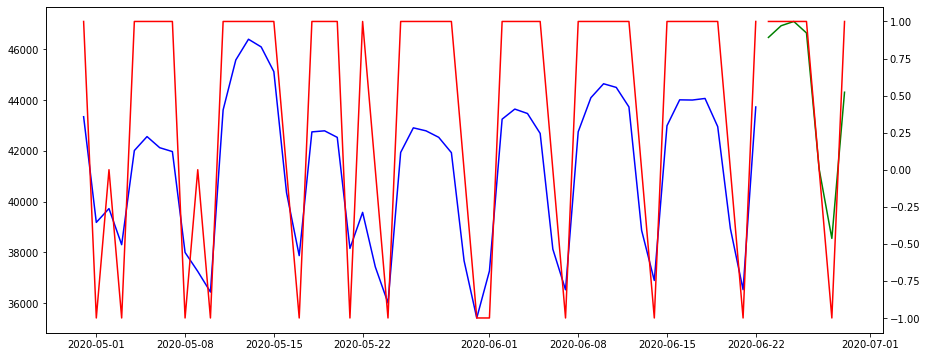

In [78]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(daily_consumption['consommation'], 
                order=(3, 1, 1), 
                seasonal_order=(3, 2, 3,7), 
                exog=daily_consumption['type_of_day'])

model_fit = model.fit(disp=False)
predictions = model_fit.get_prediction(start=start_day, end=end_day, exog=exog_test_d)
pred = predictions.predicted_mean

pred_daily = pred * df_light['consommation'].mean()

fig, ax1 = plt.subplots(figsize=(15, 6))

ax2 = ax1.twinx()

ax1.plot(daily_consumption['consommation'] * df_light['consommation'].mean(), c='b')
ax1.plot(pred_daily, c='g')

ax2.plot(daily_consumption['type_of_day'], c='r')
ax2.plot(exog_test_d, c='r')

plt.show()

In [68]:
%%time
AR = [1, 2, 3]
I = [1, 2, 3]
MA = [1, 2, 3]
seas_AR = [1, 2, 3]
seas_I = [1, 2, 3]
seas_MA = [1, 2, 3]
model_dict = dict()

for p in AR:
    for d in I:
        for q in MA:
            for P in seas_AR:
                for D in seas_I:
                    for Q in seas_MA:
                        model = SARIMAX(daily_consumption['consommation'][:-7], 
                                        order=(p, d, q), 
                                        seasonal_order=(P, D, Q,7), 
                                        exog=daily_consumption['type_of_day'][:-7])

                        model_fit = model.fit(disp=False)
                        predictions = model_fit.get_prediction(start=start_day, end=end_day, exog=exog_test_d)
                        pred = predictions.predicted_mean
                        
                        model_name = str(p) + str(d) + str(q) + str(P) + str(D) + str(Q)
                        
                        model_dict[model_name] = pred

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Con

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/v

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/v

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/v

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/v

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/v

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/v

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/v

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/v

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/v

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/v

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/v

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/v

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/v

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/v

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/v

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/v

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/v

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/v

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ranto/.pyenv/versions/3.7.6/envs/v

CPU times: user 3h 41min 48s, sys: 3h 20min 17s, total: 7h 2min 5s
Wall time: 54min 50s


In [72]:
mse = dict()

for key, value in model_dict.items():
    mse[key] = mean_squared_error(daily_consumption['consommation'][-7:], value)

In [74]:
min(mse.values())

9.469984100299875e-05

In [75]:
for key, value in mse.items():
    if value == min(mse.values()):
        print(key)

311323


### Model evaluation on past data

In [121]:
def filter_period(df, start_day, duration_days=None, duration_hours=None):
    if duration_hours == None:
        duration_hours = duration_days * 24
        
    period = pd.date_range(start=start_day, periods=duration_hours, freq='H', normalize=True, tz='UTC')
    
    return df[(df.index >= period[0]) & (df_light.index <= period[-1])]

In [146]:
def data_slices_to_list_of_dict(df, duration_days=None, duration_hours=None):
    if duration_hours == None:
        duration_hours = duration_days * 24
        
    duration_hours = 240
    data_list_of_dict = list()

    end_idx = int(duration_hours / 24 + 1)

    for start_days in df_light['day'].unique()[:-end_idx]:
        tmp_dict = {'name': start_days + ' ' + str(duration) +'h',
         'start_day': start_days,
         'duration': duration,
         'data': filter_period(df_light, start_days, duration_hours=duration_hours)}

        data_list_of_dict.append(tmp_dict)
        
    return data_list_of_dict

In [182]:
import sys
sys.path.append('../app')
from make_predictions import make_predictions
sys.path.append('../real-time-model')
from make_evaluation_models import data_list_of_dict
import matplotlib.pyplot as plt

In [198]:
pred_list = list()

for data_slice in data_list_of_dict:
    try:
        daily_consumption_path = f'../app/data/daily_consumption_{data_slice["name"]}.pkl'
        exog_train_path = f'../app/data/exog_train_{data_slice["name"]}.pkl'
        df_light_path = f'../app/data/df_light_{data_slice["name"]}.pkl'
        daily_model_path = f'../app/prediction-models/daily_model_{data_slice["name"]}.pkl'
        hourly_model_path = f'../app/prediction-models/hourly_model_{data_slice["name"]}.pkl'
        n_pred = 24

        pred_list.append(make_predictions(daily_consumption_path,
            exog_train_path,
            df_light_path,
            daily_model_path,
            hourly_model_path,
            n_pred))
        
    except:
        continue

../app/make_predictions.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type_of_day'][df['date_heure'].astype(str).str.contains(date)] = -1


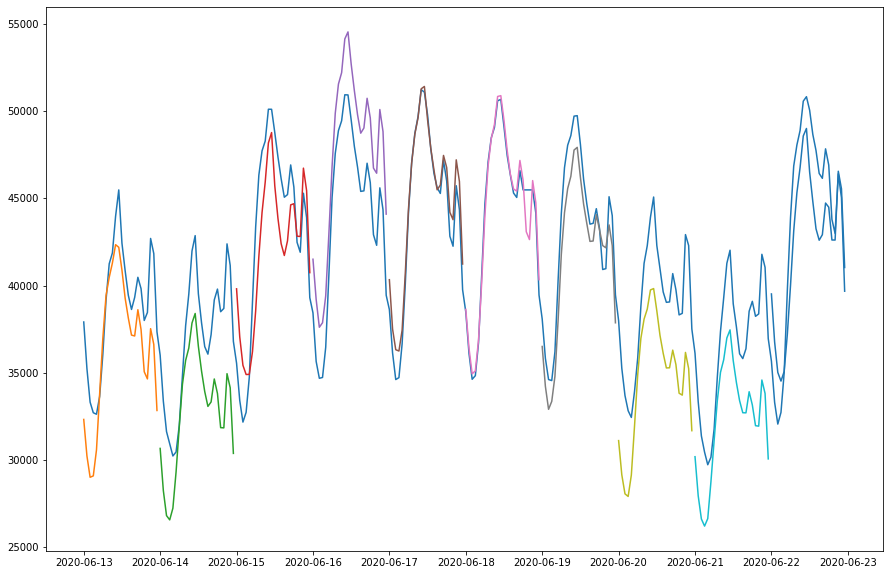

In [199]:
plt.figure(figsize=(15, 10))

plt.plot(df_light['consommation'].iloc[-240:])

for pred in pred_list[-10:]:
    plt.plot(pred)

plt.show()

In [211]:
str(pred_list[0].index[-1] + pd.to_timedelta('1D')).split(' ')[0]

'2020-05-11'